Gender Biases in Student Evaluations of Teachers
====================================================


In [1]:
# boilerplate
%matplotlib inline
import math
import numpy as np
import pandas as pd
from numpy.random import random
import scipy as sp
from scipy import special
import matplotlib.pyplot as plt
from __future__ import division

# initialize PRNG
rs = np.random.RandomState(seed=1)

Permutation test code
============
You must install the _permute_ package to use this code. Install instructions can be found at https://github.com/statlab/permute.  Our analysis uses version 0.1.alpha2.

In [14]:
from permute.core import corr  
from permute.stratified import sim_corr
import permute
print "permute: version", permute.__version__

permute: version 0.1.alpha2


## Read data and define new fields

In [9]:
#dat = pd.read_stata("../../SET data/permutation_all triplets.dta",  convert_categoricals=False )
#dat = dat[dat.admission_cep == 0]
#dat.describe()

dat = pd.read_stata("sample_permutation.dta",  convert_categoricals=False)
dat.describe()

,student_id,year,entreescpoen,stu_male,stu_female,admission_exam,admission_cep,admission_bactb,admission_other,stu_avg_final,...,history,micro,ip,macro,socio,scpo,both_female,both_male,stumale_proffemale,stufemale_profmale
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18,18.000000,...,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,2470.055664,2010.388889,2010.277778,0.500000,0.500000,0.833333,0.111111,0.055556,0,13.013118,...,0.222222,0.277778,0.166667,0.055556,0.222222,0.055556,0.222222,0.277778,0.222222,0.277778
std,1242.043335,1.243283,1.319784,0.514496,0.514496,0.383483,0.323381,0.235702,0,1.598775,...,0.427793,0.460889,0.383483,0.235702,0.427793,0.235702,0.427793,0.460889,0.427793,0.460889
min,209.000000,2008.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,9.833334,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1634.000000,2010.000000,2009.250000,0.000000,0.000000,1.000000,0.000000,0.000000,0,12.243056,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2365.500000,2010.000000,2010.000000,0.500000,0.500000,1.000000,0.000000,0.000000,0,13.270833,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3404.500000,2011.000000,2011.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0,14.090278,...,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.750000
max,4414.000000,2012.000000,2012.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,15.138889,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
evals = ['q16', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q13', 'q14', 'q15']
if isinstance(dat.q16[0], str):
    for e in evals:
        dat[e].replace(['nonpertinent', 'insuffisant', 'moyen', 'bon', 'excellent'],\
                       [0,1,2,3,4],\
                       inplace=True)
    
dat['course'] = dat['prof_id']
dat.course.loc[dat['history']==1] = 'history' 
dat.course.loc[dat['micro']==1] = 'micro' 
dat.course.loc[dat['ip']==1] = 'ip' 
dat.course.loc[dat['macro']==1] = 'macro' 
dat.course.loc[dat['socio']==1] = 'socio' 
dat.course.loc[dat['scpo']==1] = 'scpo' 

dat['gender'] = dat['prof_male']
dat.gender.loc[dat.gender==1] = 'M'
dat.gender.loc[dat.gender==0] = 'F'
dat['student_gender'] = dat['stu_male']
dat.student_gender.loc[dat.student_gender==1] = 'M'
dat.student_gender.loc[dat.student_gender==0] = 'F'

# Define the fun times for class
dat['plumTime'] = (dat['extremetime'] < 2) & dat['day'].isin([2,3,4])

# Define the permutation strata: permute independently by course/semester
dat['course_year'] = dat['course'] + dat['year'].map(str)
course_year_values = dat['course_year'].unique()
course_year_values.sort()
dat['course_year_int'] = dat['course_year']
for i in range(len(dat.course_year.unique())):
    dat.course_year_int.loc[dat.course_year == course_year_values[i]] = i
dat.course_year_int = dat.course_year_int.astype(int)

## Data filtering

Most of the analyses omit grades in PI, for two reasons: 
1. The final exam is oral
2. There is a large imbalance in the gender of the instructors: 52 male, 12 female
3. Since the course is "easy," that would bias results in favor of making male instructors look more effective

In [17]:
# remove the Political Institutions courses
datNoIp = dat.copy()
datNoIp = datNoIp[datNoIp['course'] != 'ip']

# Start of the analysis

### Ratings v student performance

In [33]:
# Correlation btw avg evaluation score and final exam grade, by course number. Omit IP courses

print 'Analyzing the correlation btw avg evaluation score and final exam grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm', 'course_year_int']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['note_cm'], 
                                          group = prof_ratings['course_year_int'], seed = rs, reps=10)
print 'Overall:'
print 'Test statistic (sum of correlations):', t
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of courses:', prof_ratings['note_cm'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', 'Two-sided p-value', '# Courses'))
for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['note_cm'], 
                                              group = prof_ratings['course_year_int'], seed = rs, reps=10)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format(topic, t, pupper, pboth, \
                                                                  prof_ratings['note_cm'].size))

Analyzing the correlation btw avg evaluation score and final exam grade, by course number
Overall:
Test statistic (sum of correlations): nan
One-sided (upper) p-value: 0.0
Two-sided p-value: 0.0
Number of courses: 15 


Course       Test stat Upper P-value Two-sided p-value # Courses
history           nan         0.00         0.00         4.00
macro             nan         0.00         0.00         1.00
micro             nan         0.00         0.00         5.00
scpo              nan         0.00         0.00         1.00
socio             nan         0.00         0.00         4.00


### Instructor gender v student performance

In [58]:
# Correlation of final exam and gender, by course.  Excludes IP courses.

print 'Correlation btw final exam average and instructor gender, by course' 

theCols = evals + ['prof_male','note_cm', 'course_year_int']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)

(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['note_cm'], y = prof_ratings['prof_male'], \
                                          group = prof_ratings['course_year_int'], seed = rs, reps = 10)
print 'Overall:'
print 'Test statistic (sum of correlations):', t
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of courses w/ male profs:', prof_ratings['prof_male'].sum()
print 'Number of courses w/ female profs:', (1-prof_ratings['prof_male']).sum()
print 'Total number of courses:', prof_ratings['prof_male'].size, '\n'



print ('\n{0:12} {1:8} {2:8} {3:8} {4:8} {5:8} {6:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Male profs', \
                                                             '# Female profs', '# Courses'))
for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['note_cm'], y = prof_ratings['prof_male'], 
                                          group = prof_ratings['course_year_int'], seed = rs, reps = 10)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f} {5:12.2f} {6:12.2f}'.format( topic, t, \
                    pupper, pboth, prof_ratings['prof_male'].sum(), \
                    (1-prof_ratings['prof_male']).sum(),  prof_ratings['prof_male'].size ))

Correlation btw final exam average and instructor gender, by course
Overall:
Test statistic (sum of correlations): nan
One-sided (upper) p-value: 0.0
Two-sided p-value: 0.0
Number of courses w/ male profs: 8.0
Number of courses w/ female profs: 7.0
Total number of courses: 15 


Course       Test stat Upper P-value Two-sided p-value # Male profs # Female profs # Courses
history           nan         0.00         0.00         3.00         1.00         4.00
ip                nan         0.00         0.00         2.00         1.00         3.00
macro             nan         0.00         0.00         1.00         0.00         1.00
micro             nan         0.00         0.00         3.00         2.00         5.00
scpo              nan         0.00         0.00         0.00         1.00         1.00
socio             nan         0.00         0.00         1.00         3.00         4.00


### Ratings v grade expectations

In [61]:
# Correlation btw avg evaluation score and avg cont assessment grades, by course number. Includes IP
print 'Analyzing the correlation btw avg evaluation score and cont assessment, by course number' 

theCols = evals + ['prof_male','plumTime','note_conf', 'course_year_int']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['note_conf'], 
                                          group = prof_ratings['course_year_int'], seed = rs, reps=10)
print 'Overall:'
print 'Test statistic (sum of correlations):', t
print 'One-sided (upper) p-value:', pupper
print 'Number of courses:', prof_ratings['note_conf'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8}'.format('Course', 'Test stat', 'Upper P-value', '# Courses'))
for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['note_conf'], 
                                          group = prof_ratings['course_year_int'], seed = rs, reps=10)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f}'.format( topic, t, \
                    pupper, prof_ratings['note_conf'].size ))    
    

Analyzing the correlation btw avg evaluation score and cont assessment, by course number
Overall:
Test statistic (sum of correlations): nan
One-sided (upper) p-value: 0.0
Number of courses: 18 


Course       Test stat Upper P-value # Courses
history           nan         0.00         4.00
ip                nan         0.00         3.00
macro             nan         0.00         1.00
micro             nan         0.00         5.00
scpo              nan         0.00         1.00
socio             nan         0.00         4.00


### Ratings v instructor gender

In [62]:
# Correlation of avg evaluation score and gender, by course.  Includes IP courses.

print 'Analyzing the correlation btw avg evaluation score and gender, by course' 

theCols = evals + ['prof_male','plumTime', 'course_year_int']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)

(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['prof_male'], 
                                          group = prof_ratings['course_year_int'], seed = rs, reps=10)
print 'Overall:'
print 'Test statistic (sum of correlations):', t
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections w/ male profs:', prof_ratings['prof_male'].sum()
print 'Number of sections w/ female profs:', (1-prof_ratings['prof_male']).sum()
print 'Total number of courses:', prof_ratings['prof_male'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8} {5:8} {6:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Male profs', \
                                                             '# Female profs', '# Sections'))
for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['prof_male'], 
                                              group = prof_ratings['course_year_int'], seed = rs, reps=10)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f} {5:12.2f} {6:12.2f}'.format( topic, t, \
                    pupper, pboth, prof_ratings['prof_male'].sum(), \
                    (1-prof_ratings['prof_male']).sum(),  prof_ratings['prof_male'].size ))

Analyzing the correlation btw avg evaluation score and gender, by course
Overall:
Test statistic (sum of correlations): nan
One-sided (upper) p-value: 0.0
Two-sided p-value: 0.0
Number of courses w/ male profs: 10.0
Number of courses w/ female profs: 8.0
Total number of courses: 18 


Course       Test stat Upper P-value Two-sided p-value # Male profs # Female profs # Courses
history           nan         0.00         0.00         3.00         1.00         4.00
ip                nan         0.00         0.00         2.00         1.00         3.00
macro             nan         0.00         0.00         1.00         0.00         1.00
micro             nan         0.00         0.00         3.00         2.00         5.00
scpo              nan         0.00         0.00         0.00         1.00         1.00
socio             nan         0.00         0.00         1.00         3.00         4.00


### Ratings and gender concordance

In [71]:
# Gender concordance v overall satisfaction, grouped by course
# This looks at how students rate their profs, by course

dMale_stu = dat[dat['stu_male']==1]
dFemale_stu = dat[dat['stu_female']==1]

theCols = evals + ['prof_male','prof_female','plumTime','note_cm', 'course_year_int']

groupedMale = dMale_stu.groupby(['course_number'])
groupedFemale = dFemale_stu.groupby(['course_number'])
prof_ratings_M = groupedMale[theCols].agg(np.mean)
prof_ratings_F = groupedFemale[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings_M['q16'], y = prof_ratings_M['prof_male'], 
                                          group = prof_ratings_M['course_year_int'], seed = rs, reps=10)
print 'Male students\n'
print 'Overall:'
print 'Test statistic (sum of correlations):', t
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections with male students:', prof_ratings_M['prof_male'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Sections'))
for topic in np.unique(dMale_stu['course']):
    perTopic = dMale_stu[dMale_stu['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['prof_male'], 
                                              group = prof_ratings['course_year_int'], seed = rs, reps=10)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format( topic, t, \
                    pupper, pboth, prof_ratings['prof_male'].size ))

print '\n\nFemale students\n'
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings_F['note_cm'], y = prof_ratings_F['prof_female'],\
                                      seed = rs)
print 'Overall:'
print 'Test statistic (sum of correlations):', t
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections with female students:', prof_ratings_F['prof_female'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Sections'))
for topic in np.unique(dFemale_stu['course']):
    perTopic = dFemale_stu[dFemale_stu['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['prof_female'], 
                                              group = prof_ratings['course_year_int'], seed = rs, reps=10)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format( topic, t, \
                    pupper, pboth, prof_ratings['prof_female'].size ))

Male students

Overall:
Test statistic (sum of correlations): nan
One-sided (upper) p-value: 0.0
Two-sided p-value: 0.0
Number of sections with male students: 9 


Course       Test stat Upper P-value Two-sided p-value # Sections
history           nan         0.00         0.00         2.00
ip                nan         0.00         0.00         2.00
micro             nan         0.00         0.00         3.00
socio             nan         0.00         0.00         2.00


Female students

Overall:
Test statistic (sum of correlations): 0.465875904876
One-sided (upper) p-value: 0.102
Two-sided p-value: 0.1845
Number of sections with female students: 9 


Course       Test stat Upper P-value Two-sided p-value # Sections
history           nan         0.00         0.00         2.00
ip                nan         0.00         0.00         1.00
macro             nan         0.00         0.00         1.00
micro             nan         0.00         0.00         2.00
scpo              nan         

### Student performance and gender concordance

In [73]:
# Gender concordance v final exam scores, grouped by course. Excludes IP

dMale_stu = datNoIp[datNoIp['stu_male']==1]
dFemale_stu = datNoIp[datNoIp['stu_female']==1]

theCols = evals + ['prof_male','prof_female','plumTime','note_cm', 'course_year_int']

groupedMale = dMale_stu.groupby(['course_number'])
groupedFemale = dFemale_stu.groupby(['course_number'])
prof_ratings_M = groupedMale[theCols].agg(np.mean)
prof_ratings_F = groupedFemale[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings_M['note_cm'], y = prof_ratings_M['prof_male'], 
                                          group = prof_ratings_M['course_year_int'], seed = rs, reps=10)
print 'Male students\n'
print 'Overall:'
print 'Test statistic (sum of correlations):', t
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections with male students:', prof_ratings_M['prof_male'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Sections'))
    
for topic in np.unique(dMale_stu['course']):
    perTopic = dMale_stu[dMale_stu['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['note_cm'], y = prof_ratings['prof_male'], 
                                              group = prof_ratings['course_year_int'], seed = rs, reps=10)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format( topic, t, \
                    pupper, pboth, prof_ratings['prof_male'].size ))
    
    
print '\n\nFemale students \n'
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings_F['note_cm'], y = prof_ratings_F['prof_female'], seed = rs)
print 'Overall:'
print 'Test statistic (sum of correlations):', t
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections with female students:', prof_ratings_F['prof_female'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Sections'))

for topic in np.unique(dFemale_stu['course']):
    perTopic = dFemale_stu[dFemale_stu['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['note_cm'], y = prof_ratings['prof_female'], 
                                              group = prof_ratings['course_year_int'], seed = rs, reps=10)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format( topic, t, \
                    pupper, pboth, prof_ratings['prof_female'].size ))

Male students

Overall:
Test statistic (sum of correlations): nan
One-sided (upper) p-value: 0.0
Two-sided p-value: 0.0
Number of sections with male students: 7 


Course       Test stat Upper P-value Two-sided p-value # Sections
history           nan         0.00         0.00         2.00
micro             nan         0.00         0.00         3.00
socio           -1.00         1.00         1.00         2.00


Female students 

Overall:
Test statistic (sum of correlations): 0.50251890763
One-sided (upper) p-value: 0.1134
Two-sided p-value: 0.233
Number of sections with female students: 8 


Course       Test stat Upper P-value Two-sided p-value # Sections
history           nan         0.00         0.00         2.00
macro             nan         0.00         0.00         1.00
micro             nan         0.00         0.00         2.00
scpo              nan         0.00         0.00         1.00
socio             nan         0.00         0.00         2.00


### Association between evaluation scores and class meeting time

In [75]:
# Correlation of avg evaluation score and desirable time, by course. Includes IP courses
print 'Analyzing the correlation btw avg evaluation score and desirable time, by course' 

theCols = evals + ['prof_male','plumTime', 'course_year_int']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['plumTime'], 
                                          group = prof_ratings['course_year_int'], seed = rs, reps=10)
print 'Overall:'
print 'Test statistic (sum of correlations):', t
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections with desirable times:', prof_ratings['plumTime'].sum()
print 'Number of sections with undesirable times:', (1-prof_ratings['plumTime']).sum()
print 'Total number of sections:', prof_ratings['plumTime'].size, '\n'


print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Sections'))
for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['plumTime'], 
                                              group = prof_ratings['course_year_int'], seed = rs, reps=10)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format( topic, t, \
                    pupper, pboth, prof_ratings['plumTime'].size ))

Analyzing the correlation btw avg evaluation score and desirable time, by course
Overall:
Test statistic (sum of correlations): nan
One-sided (upper) p-value: 0.0
Two-sided p-value: 0.0
Number of sections with desirable times: 10
Number of sections with undesirable times: 8
Total number of sections: 18 


Course       Test stat Upper P-value Two-sided p-value # Sections
history           nan         0.00         0.00         4.00
ip                nan         0.00         0.00         3.00
macro             nan         0.00         0.00         1.00
micro             nan         0.00         0.00         5.00
scpo              nan         0.00         0.00         1.00
socio             nan         0.00         0.00         4.00


### Reliability, self-declared investment in a course

(array([   78.,   753.,  6255.,  7524.,  4428.,  1557.]),
 array([ 4.        ,  4.83333333,  5.66666667,  6.5       ,  7.33333333,
         8.16666667,  9.        ]),
 <a list of 6 Patch objects>)

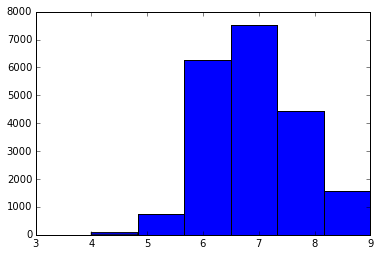

In [13]:
# dat with IP => to test for reliability on q10 (student self-assessed involvment in the course)

wrkld=dat[dat['three_evals']==1]['sum_q10']
plt.hist (wrkld.values, bins=6)

# Other analyses, not in paper

### Ratings and performance, pooled genders and stratified

In [14]:
# test association between ratings and performance, pooled genders.
# Since this uses the final exams, eliminate the IP courses

# group the data by instructor, discipline, gender, student gender

grouped = datNoIp.groupby(['prof_id', 'course', 'gender', 'student_gender'])
prof_ratings = grouped[evals].mean()

pass_fail = lambda x: np.mean([xx >= 10 for xx in x])
pass_rate = grouped['note_finale'].agg([np.mean,pass_fail])

teacher_data = pd.concat([prof_ratings, pass_rate], axis=1)
teacher_data = teacher_data.rename(columns = {'mean':'mean_final_exam', '<lambda>':'pass_rate'}).reset_index()

# Test association between ratings performance, pooled genders.
(t, plower, pupper, pboth, sims) = corr(x = teacher_data.q16, y = teacher_data.mean_final_exam, seed = rs)
print 'Ratings v. performance, pooled gender:',t, plower, pupper, pboth

# Test association between ratings performance, stratified by gender.
(t, plower, pupper, pboth, sims) = stratified.sim_corr(x = teacher_data.q16, y = teacher_data.mean_final_exam,
                                            group = teacher_data.gender, seed = rs)
print 'Ratings v. performance, stratified by gender:', t, plower, pupper, pboth

Ratings v. performance, pooled gender: 0.0502515031961 0.9155 0.0845 0.1693
Ratings v. performance, stratified by gender: 0.0756405768649 0.8389 0.1611 0.3331


### Ratings v instructor gender

In [ ]:
grouped = dat.groupby(['prof_id'])
theCols = evals + ['prof_male', 'course_year_int']  # evaluation columns, plus indicator for male prof

prof_ratings = grouped[theCols].agg(np.mean)

(t, plower, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.prof_male, seed = rs)

print 'mean rating for instructors vs. instructor gender (positive favors males):', t, plower, pupper, pboth

mean rating for instructors vs. instructor gender (positive favors males): 0.102402402911 0.9763 0.0237 0.0475


### Instructor gender and student performance, student level

In [ ]:
# remove students who took triads from instructors all of the same gender or who have missing final grades.
# Since this uses final exams, remove IP courses

datNonzeroVar = datNoIp.copy()
for g in np.unique(dat['student_id']):
    gg = dat['student_id'] == g
    if (np.var(datNoIp['note_cm'][gg]) == 0.0) or (np.var(datNoIp['prof_male'][gg]) == 0.0) or \
        np.any(np.isnan(datNoIp['note_cm'][gg])):
        datNonzeroVar = datNonzeroVar.drop(datNonzeroVar[datNonzeroVar['student_id'] == g].index)

(t, plower, pupper, pboth, sims) = stratified.sim_corr(x = datNonzeroVar[~np.isnan(datNonzeroVar['note_cm'])]['prof_male'],\
                                    y = datNonzeroVar[~np.isnan(datNonzeroVar['note_cm'])]['note_cm'],\
                                    group = datNonzeroVar[~np.isnan(datNonzeroVar['note_cm'])]['student_id'],\
                                    seed = rs, reps=10**3)
                                           
print 'Student-level association between instructor gender and performance:', t, plower, pupper, pboth

### Association between instructors' average ratings and average continuous assessment grades, by teacher id

In [ ]:
# Correlation of avg evaluation score and avg cont assessment grades, by instructor. 
# Includes IP courses

print 'Analyzing the correlation btw avg evaluation score and cont assessment, by instructor' 

theCols = evals + ['prof_male','plumTime','note_conf', 'course_year_int']

grouped = dat.groupby(['prof_id'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q16'], y = prof_ratings['note_conf'], seed = rs)
print 'overall', t, pupper,\
       prof_ratings['note_conf'].size, '\n'

for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['prof_id'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q16'], y = prof_ratings['note_conf'], seed = rs)
    print topic, t, pupper, prof_ratings['note_conf'].size
    
    

### Association between concordance of student and teacher genders and overall satisfaction

In [ ]:
# Correlation of concordance of student and teacher genders and overall satisfaction. Includes IP courses.
print 'Correlation of concordance of student and teacher genders and overall satisfaction'
# Male instructors first

dMale = dat[dat['prof_male']==1]
dFemale = dat[dat['prof_female']==1]

(t, plow, pupper, pboth, sims) = corr(x=dMale['q16'], y=dMale['stu_male'], reps=10**5, seed=rs)
print 'Male instructors:', t, pupper

# Female instructors

(t, plow, pupper, pboth, sims) = corr(x=dFemale['q16'], y=dFemale['stu_female'], reps=10**5, seed=rs)
print 'Female instructors:', t, pupper

### Dimensions of teaching analyses

In [ ]:
# Correlation of avg teaching dimension scores and final exam grade, by course number.
# Excludes IP.
print 'Analyzing the correlation btw teaching dimension scores and final exam grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm', 'course_year_int']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q5'], y = prof_ratings['note_cm'], seed = rs)
print 'overall', t, pupper,\
       prof_ratings['note_cm'].size, '\n'

for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q5'], y = prof_ratings['note_cm'], seed = rs)
    print topic, t, pupper, prof_ratings['note_cm'].size
    
    

In [ ]:
# Correlation of avg teaching dimension scores and final exam grade, by course number.
# Since this uses final, omit IP courses

print 'Analyzing the correlation btw teaching dimension scores and final exam grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm', 'course_year_int']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q5'], y = prof_ratings['note_cm'], seed = rs)

print 'overall', t, pupper,\
       prof_ratings['note_cm'].size, '\n'

for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q5'], y = prof_ratings['note_cm'], seed = rs)
    print topic, t, pupper, prof_ratings['note_cm'].size

### Gender concordance analyses

In [ ]:
# Gender concordance v continuous assessment grade. Include IP. 
# This looks at how profs are rated by students.

dMale = dat[dat['prof_male']==1]
dMale = dMale[~np.isnan(dMale['note_conf'])]
              
dFemale = dat[dat['prof_female']==1]
dFemale = dFemale[~np.isnan(dFemale['note_conf'])]

(t, plow, pupper, pboth, sims) = corr(x=dMale['note_conf'], y=dMale['stu_male'], seed=rs)
print 'Concordance of genders v continuous assessment, male instructors:', t, pupper
                  
(t, plow, pupper, pboth, sims) = corr(x=dFemale['note_conf'], y=dFemale['stu_female'], seed=rs)
print 'Concordance of genders v continuous assessment, female instructors:', t, pupper

In [ ]:
# Gender concordance v preparation & organization. Includes IP courses.
# This looks at how profs are rated by students.

# redundant, but safe:
dMale = dat[dat['prof_male']==1]
dMale = dMale[~np.isnan(dMale['q1'])]  # note! need to re-set in following analyses

dFemale = dat[dat['prof_female']==1]
dFemale = dFemale[~np.isnan(dFemale['q1'])]  # note! need to re-set in following analyses

# Male instructors
(t, plow, pupper, pboth, sims) = corr(x=dMale['q1'], y=dMale['stu_male'], seed=rs)
print 'Gender concordance v. preparation and organization, male instructors:', t, pupper

# Female instructors
(t, plow, pupper, pboth, sims) = corr(x=dFemale['q1'], y=dFemale['stu_female'], seed=rs)
print 'Gender concordance v. preparation and organization, female instructors:', t, pupper

In [ ]:
# Gender concordance v quality of instructional material. Includes IP courses.
# This looks at how profs are rated by students.

# redundant, but safe:
dMale = dat[dat['prof_male']==1]
dMale = dMale[~np.isnan(dMale['q2'])]  # note! need to re-set in following analyses

dFemale = dat[dat['prof_female']==1]
dFemale = dFemale[~np.isnan(dFemale['q2'])]  # note! need to re-set in following analyses

# Male instructors
(t, plow, pupper, pboth, sims) = corr(x=dMale['q2'], y=dMale['stu_male'], seed=rs)
print 'Gender concordance v. preparation and organization, male instructors:', t, pupper

# Female instructors
(t, plow, pupper, pboth, sims) = corr(x=dFemale['q2'], y=dFemale['stu_female'], seed=rs)
print 'Gender concordance v. preparation and organization, female instructors:', t, pupper

In [ ]:
# Gender concordance v quality of animation. Includes IP courses
# This looks at how profs are rated by students.

dMale = dat[dat['prof_male']==1]
dMale = dMale[~np.isnan(dMale['q5'])]
              
dFemale = dat[dat['prof_female']==1]
dFemale = dFemale[~np.isnan(dFemale['q5'])]

(t, plow, pupper, pboth, sims) = corr(x=dMale['q5'], y=dMale['stu_male'], seed=rs)
print 'Gender concordance v animation, male instructors:', t, pupper

(t, plow, pupper, pboth, sims) = corr(x=dFemale['q5'], y=dFemale['stu_female'], seed=rs)
print 'Gender concordance v animation, female instructors:', t, pupper

### Differences in continuous assessment and final exam grades analyses

In [ ]:
# Correlation btw avg evaluation score and difference btw continuous assessment and final grade, by course number
# Exclude IP courses
print 'Avg evaluation score v difference btw continuous assessment & final grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm', 'diff_final_cont', 'course_year_int']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q16'], y = prof_ratings['diff_final_cont'], seed = rs)
print 'overall', t, pupper,\
       prof_ratings['diff_final_cont'].size, '\n'

for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q16'], y = prof_ratings['diff_final_cont'], seed = rs)
    print topic, t, pupper, prof_ratings['diff_final_cont'].size 

In [ ]:
# Gender concordance v and difference btw continuous assessment and final grade. Includes IP courses
# This looks at how profs grade students compared to their actual level.

dMale = dat[dat['prof_male']==1]
dMale = dMale[~np.isnan(dMale['diff_final_cont'])]
              
dFemale = dat[dat['prof_female']==1]
dFemale = dFemale[~np.isnan(dFemale['diff_final_cont'])]

(t, plow, pupper, pboth, sims) = corr(x=dMale['diff_final_cont'], y=dMale['stu_male'], seed=rs)
print 'Gender concordance v difference btw continuous assessment and final grade, male instructors:', t, pupper

(t, plow, pupper, pboth, sims) = corr(x=dFemale['diff_final_cont'], y=dFemale['stu_female'], seed=rs)
print 'Gender concordance v difference btw continuous assessment and final grade, female instructors:', t, pupper